In [3]:
# Importing Libraries
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt  

import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from nltk.tokenize import word_tokenize

In [4]:
# Load dataset
ds, info = tfds.load(
    'wmt14_translate/de-en', 
    split=['train', 'validation'], 
    as_supervised=True, 
    with_info=True
)
train_examples, val_examples = ds
train_examples = train_examples.take(25000)
print("Train size:", len(train_examples))
print("Validation size:", len(val_examples))   
print(train_examples.take(1).get_single_element())

Train size: 25000
Validation size: 3000
(<tf.Tensor: shape=(), dtype=string, numpy=b'An der B 211 befindet sich in Loyermoor der so genannte \xe2\x80\x9eGeest-Abbruch\xe2\x80\x9c, der eine H\xc3\xb6hendifferenz von gut 30 Meter \xc3\xbcberbr\xc3\xbcckt.'>, <tf.Tensor: shape=(), dtype=string, numpy=b'Here the largest town of the district is located: Nordenham , lying opposite to Bremerhaven at the Weser mouth.'>)


In [5]:
# Tokenization and preprocessing
tokenizer_en = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    (en.numpy() for _, en in train_examples), target_vocab_size=2**13)
tokenizer_de = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    (de.numpy() for de, _ in train_examples), target_vocab_size=2**13)

VOCAB_SIZE_EN = tokenizer_en.vocab_size + 2
VOCAB_SIZE_DE = tokenizer_de.vocab_size + 2
START_TOKEN, END_TOKEN = [VOCAB_SIZE_DE - 2], [VOCAB_SIZE_DE - 1]

In [6]:
def encode(de, en):
    de = START_TOKEN + tokenizer_de.encode(de.numpy()) + END_TOKEN
    en = tokenizer_en.encode(en.numpy()) + [tokenizer_en.vocab_size + 1]
    return de, en

def tf_encode(de, en):
    de, en = tf.py_function(encode, [de, en], [tf.int64, tf.int64])
    de.set_shape([None])
    en.set_shape([None])
    return de, en

train_dataset = train_examples.map(tf_encode)
train_dataset = train_dataset.filter(lambda x, y: tf.logical_and(tf.size(x) <= 40, tf.size(y) <= 40))
train_dataset = train_dataset.padded_batch(64, padded_shapes=([None], [None]))

In [7]:
# Positional Encoding
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis], np.arange(d_model)[np.newaxis, :], d_model)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

# Attention blocks
def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    output = tf.matmul(attention_weights, v)
    return output

def split_heads(x, num_heads):
    batch_size = tf.shape(x)[0]
    seq_len = tf.shape(x)[1]
    depth = x.shape[2] // num_heads
    x = tf.reshape(x, (batch_size, seq_len, num_heads, depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])

def multi_head_attention(q, k, v, mask, num_heads, dense_q, dense_k, dense_v, dense_out):
    d_model = q.shape[-1]
    wq = dense_q(q)
    wk = dense_k(k)
    wv = dense_v(v)
    q_split = split_heads(wq, num_heads)
    k_split = split_heads(wk, num_heads)
    v_split = split_heads(wv, num_heads)
    scaled_attention = scaled_dot_product_attention(q_split, k_split, v_split, mask)
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
    concat_attention = tf.reshape(scaled_attention, (tf.shape(q)[0], -1, d_model))
    return dense_out(concat_attention)

In [8]:
# Transformer hyperparameters
num_heads = 4
d_model = 128
dff = 512

# Shared layers
embedding_de = tf.keras.layers.Embedding(VOCAB_SIZE_DE, d_model)
embedding_en = tf.keras.layers.Embedding(VOCAB_SIZE_EN, d_model)
pos_encoding = positional_encoding(1000, d_model)

# Encoder/decoder attention layers
dense_q = tf.keras.layers.Dense(d_model)
dense_k = tf.keras.layers.Dense(d_model)
dense_v = tf.keras.layers.Dense(d_model)
dense_out = tf.keras.layers.Dense(d_model)

# Second attention block in decoder
dense_q2 = tf.keras.layers.Dense(d_model)
dense_k2 = tf.keras.layers.Dense(d_model)
dense_v2 = tf.keras.layers.Dense(d_model)
dense_out2 = tf.keras.layers.Dense(d_model)

# Final output layer
final_dense = tf.keras.layers.Dense(VOCAB_SIZE_EN)

## <b>Transformer Architecture</b>

In [9]:
# Define LayerNormalization layers outside the transformer function
ln_enc1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)  # Encoder after self-attention
ln_enc2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)  # Encoder after FFN
ln_dec1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)  # Decoder after self-attention
ln_dec2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)  # Decoder after encoder-decoder attention
ln_dec3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)  # Decoder after FFN

# Feed-forward networks
ffn_enc = tf.keras.Sequential([tf.keras.layers.Dense(dff, activation='relu'), tf.keras.layers.Dense(d_model)])
ffn_dec = tf.keras.Sequential([tf.keras.layers.Dense(dff, activation='relu'), tf.keras.layers.Dense(d_model)])

def transformer(inp, tar):
    inp_padding_mask = tf.cast(tf.math.equal(inp, 0), tf.float32)[:, tf.newaxis, tf.newaxis, :]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((tf.shape(tar)[1], tf.shape(tar)[1])), -1, 0)
    tar_padding_mask = tf.cast(tf.math.equal(tar, 0), tf.float32)[:, tf.newaxis, tf.newaxis, :]
    combined_mask = tf.maximum(look_ahead_mask, tar_padding_mask)

    inp_embed = embedding_de(inp) + pos_encoding[:, :tf.shape(inp)[1], :]
    tar_embed = embedding_en(tar) + pos_encoding[:, :tf.shape(tar)[1], :]

    enc_out = multi_head_attention(inp_embed, inp_embed, inp_embed, inp_padding_mask, num_heads, dense_q, dense_k, dense_v, dense_out)
    enc_out = ln_enc1(inp_embed + enc_out)
    enc_out = ln_enc2(enc_out + ffn_enc(enc_out))

    dec_out = multi_head_attention(tar_embed, tar_embed, tar_embed, combined_mask, num_heads, dense_q, dense_k, dense_v, dense_out)
    dec_out = ln_dec1(tar_embed + dec_out)
    dec_out2 = multi_head_attention(dec_out, enc_out, enc_out, inp_padding_mask, num_heads, dense_q2, dense_k2, dense_v2, dense_out2)
    dec_out2 = ln_dec2(dec_out + dec_out2)
    dec_out = ln_dec3(dec_out2 + ffn_dec(dec_out2))

    return final_dense(dec_out)

In [10]:
# Loss and optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    return tf.reduce_sum(loss_ * mask) / tf.reduce_sum(mask)

optimizer = tf.keras.optimizers.Adam()

In [11]:
# Training Step
@tf.function
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    with tf.GradientTape() as tape:
        predictions = transformer(inp, tar_inp)
        loss = loss_function(tar_real, predictions)

    variables = tape.watched_variables()
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))

    return loss

In [12]:
# Training Loop
batch_losses = []  # Store loss for each batch
epoch_avg_losses = []

for epoch in range(15):
    epoch_loss = 0
    for (batch, (inp, tar)) in enumerate(train_dataset):
        batch_loss = train_step(inp, tar)
        batch_losses.append(batch_loss)

        epoch_loss += batch_loss
        if batch % 100 == 0:
            print(f"Epoch {epoch + 1}, Batch {batch}, Loss {batch_loss:.4f}")

    epoch_avg_losses.append(epoch_loss / (batch + 1))
    print(f"Epoch {epoch + 1} Loss: {epoch_loss / (batch + 1):.4f}")

Epoch 1, Batch 0, Loss 9.0216
Epoch 1, Batch 100, Loss 6.6664
Epoch 1, Batch 200, Loss 6.1742
Epoch 1 Loss: 6.6885
Epoch 2, Batch 0, Loss 5.9418
Epoch 2, Batch 100, Loss 5.6129
Epoch 2, Batch 200, Loss 5.6629
Epoch 2 Loss: 5.6838
Epoch 3, Batch 0, Loss 5.3919
Epoch 3, Batch 100, Loss 5.1004
Epoch 3, Batch 200, Loss 5.1998
Epoch 3 Loss: 5.2325
Epoch 4, Batch 0, Loss 4.9894
Epoch 4, Batch 100, Loss 4.6686
Epoch 4, Batch 200, Loss 4.8857
Epoch 4 Loss: 4.8361
Epoch 5, Batch 0, Loss 4.5951
Epoch 5, Batch 100, Loss 4.2774
Epoch 5, Batch 200, Loss 4.5210
Epoch 5 Loss: 4.4671
Epoch 6, Batch 0, Loss 4.2726
Epoch 6, Batch 100, Loss 3.9244
Epoch 6, Batch 200, Loss 4.2173
Epoch 6 Loss: 4.1407
Epoch 7, Batch 0, Loss 3.9577
Epoch 7, Batch 100, Loss 3.6502
Epoch 7, Batch 200, Loss 3.8900
Epoch 7 Loss: 3.8365
Epoch 8, Batch 0, Loss 3.6717
Epoch 8, Batch 100, Loss 3.4745
Epoch 8, Batch 200, Loss 3.5537
Epoch 8 Loss: 3.5373
Epoch 9, Batch 0, Loss 3.4355
Epoch 9, Batch 100, Loss 3.2163
Epoch 9, Batch 200

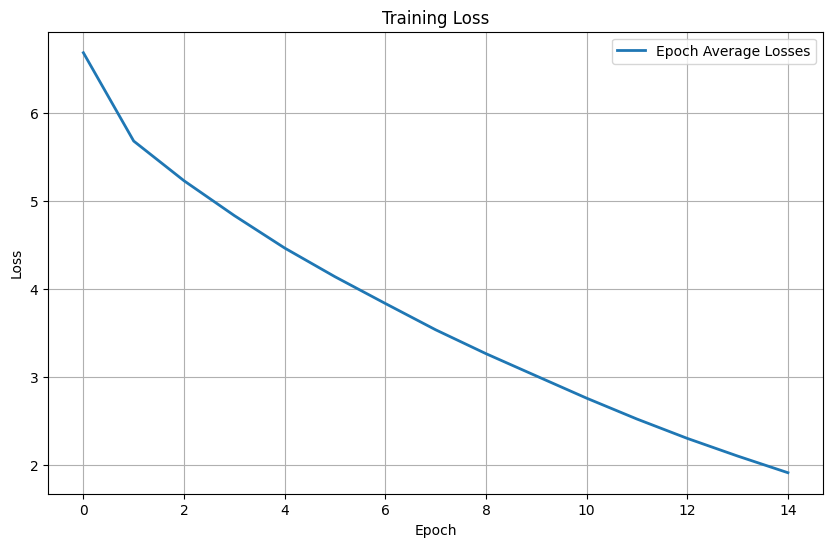

In [13]:
# Plotting the loss
plt.figure(figsize=(10, 6))
plt.plot(range(len(epoch_avg_losses)), epoch_avg_losses, label='Epoch Average Losses', linewidth=2)
plt.title('Training Loss')  
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

<hr>

## <b>Calculating Scores</b>

In [14]:
# Define special tokens for the target (English)
START_TOKEN_EN = VOCAB_SIZE_EN - 2  # Consistent with input convention
END_TOKEN_EN = VOCAB_SIZE_EN - 1    # Matches training end token

# Inference function to generate translation for a single German sentence
def generate_translation(transformer, de, max_length=40):
    de_str = de.numpy().decode('utf-8')
    tokens_de = [START_TOKEN[0]] + tokenizer_de.encode(de_str) + [END_TOKEN[0]]  # Use integers, not lists
    tokens_de = tf.convert_to_tensor(tokens_de, dtype=tf.int64)
    tokens_de = tf.expand_dims(tokens_de, 0)

    # Initialize target sequence with start token
    tar = tf.convert_to_tensor([START_TOKEN_EN], dtype=tf.int64)
    tar = tf.expand_dims(tar, 0)

    output_sequence = []
    
    # Generate tokens step-by-step
    for _ in range(max_length):
        predictions = transformer(tokens_de, tar)
        last_pred = predictions[0, -1, :]  # Prediction for the last position
        next_token = tf.argmax(last_pred).numpy()  # Convert to Python integer
        
        if next_token == END_TOKEN_EN:
            break
        
        output_sequence.append(next_token)
        tar = tf.concat([tar, tf.constant([[next_token]], dtype=tf.int64)], axis=1)

    # Decode the generated sequence to text
    generated_en = tokenizer_en.decode(output_sequence)
    return generated_en

In [15]:
# Evaluation on the validation set
bleu_scores = []
meteor_scores = []
smoothie = SmoothingFunction().method1  # For smoothing BLEU scores

print("Generating translations and calculating scores...")
for idx, (de, en) in enumerate(val_examples):
    # Generate translation
    generated_en = generate_translation(transformer, de)
    
    # Get reference translation
    ref = en.numpy().decode('utf-8')
    
    # Tokenize reference and hypothesis
    ref_tokens = word_tokenize(ref)
    hyp_tokens = word_tokenize(generated_en)
    
    # METEOR score
    meteor = meteor_score([ref_tokens], hyp_tokens)
    meteor_scores.append(meteor)
    
    # BLEU score
    bleu = sentence_bleu([ref_tokens], hyp_tokens, smoothing_function=smoothie)
    bleu_scores.append(bleu)
    
    if idx % 100 == 0:
        print(f"Processed {idx} examples")

# Calculate average scores
avg_bleu = sum(bleu_scores) / len(bleu_scores)
avg_meteor = sum(meteor_scores) / len(meteor_scores)

print(f"\nEvaluation Results:")
print(f"Average BLEU Score: {avg_bleu:.4f}")
print(f"Average METEOR Score: {avg_meteor:.4f}")

Generating translations and calculating scores...
Processed 0 examples
Processed 100 examples
Processed 200 examples
Processed 300 examples
Processed 400 examples
Processed 500 examples
Processed 600 examples
Processed 700 examples
Processed 800 examples
Processed 900 examples
Processed 1000 examples
Processed 1100 examples
Processed 1200 examples
Processed 1300 examples
Processed 1400 examples
Processed 2200 examples
Processed 2300 examples
Processed 2400 examples
Processed 2500 examples
Processed 2600 examples
Processed 2700 examples
Processed 2800 examples
Processed 2900 examples

Evaluation Results:
Average BLEU Score: 0.0176
Average METEOR Score: 0.1262


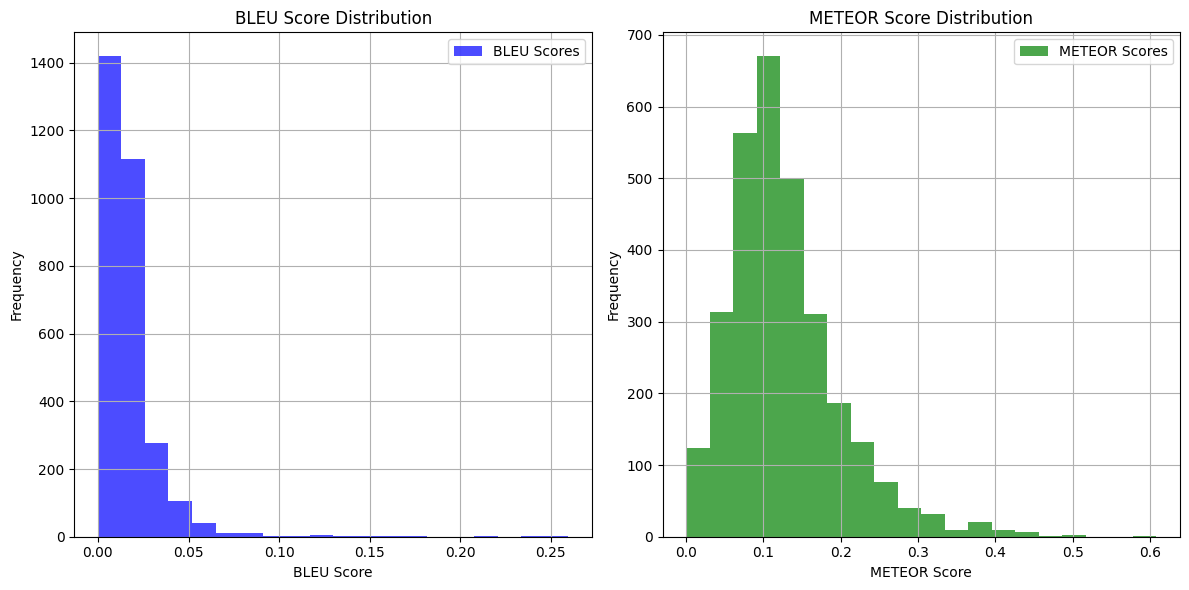

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].hist(bleu_scores, bins=20, color='blue', alpha=0.7)
axs[0].set_title('BLEU Score Distribution')
axs[0].set_xlabel('BLEU Score')
axs[0].set_ylabel('Frequency')
axs[0].legend(['BLEU Scores'])
axs[0].grid(True)

axs[1].hist(meteor_scores, bins=20, color='green', alpha=0.7)
axs[1].set_title('METEOR Score Distribution')
axs[1].set_xlabel('METEOR Score')
axs[1].set_ylabel('Frequency')
axs[1].legend(['METEOR Scores'])
axs[1].grid(True)

plt.tight_layout()
plt.show()

<hr>

## <b>Prediction</b>

In [17]:
# Making prediction using sample sentence from val dataset
print("\nSample Prediction:")
sample_de, sample_en = next(iter(val_examples.take(1)))
generated_en = generate_translation(transformer, sample_de)
reference_en = sample_en.numpy().decode('utf-8')
print(f"Input German: {sample_de.numpy().decode('utf-8')}")
print(f"Predicted English: {generated_en}")
print(f"Reference English: {reference_en}")


Sample Prediction:
Input German: Dies führt dazu, dass ein Spieler wie ich, die Stirn bieten muss und sein Bestes geben will.
Predicted English: it is that as a radio and the rest of the bank will be desired.
Reference English: Which is what makes a player like me want to face up and give my best.


In [18]:
# Making prediction using custom example
custom_de = tf.constant("Ein Beispielsatz zum Testen.", dtype=tf.string)  # Eng: An example sentence for testing
generated_en = generate_translation(transformer, custom_de)
print(f"Input German: {custom_de.numpy().decode('utf-8')}")
print(f"Predicted English: {generated_en}")

Input German: Ein Beispielsatz zum Testen.
Predicted English: allows to use to buy port.


-> As shown by the scores which are very low, the translation is disaster. No where even close. This can be due to the reason that the number of encoders and decoders are only 1.

<hr>